### Bayesian analysis of battery discharge measurements

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import warnings

In [2]:
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

In [3]:
from scipy import spatial

In [4]:
# Ignore future warnings.
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
az.style.use('seaborn-v0_8-darkgrid')

#### Battery discharge measurements (first cycle)

In [ ]:
# Excel file contains sheets, one for each discharge measurement.
file_name = 'measurements.xlsx'
# Sheet names:
discharges = [
    '21-11-25',  # first discharge measurement
    '05-12-25',
    '22-12-25',
    '05-01-26',
    '16-01-26',
]

In [ ]:
# Dictionary of dataframes, one for each excel sheet.
dataset = {}
for name in discharges:
    df = pd.read_excel(file_name, sheet_name=name)
    dataset[name] = df

In [14]:
# Measurements from the first discharge test.
data = dataset[discharges[0]].copy()
data

,Battery,X/cm,Y/cm,Zi,Rij,Ui(0),Ui(6),Ui(12),Ui(18),Ui(24),...,Ti(36),Ti(42),Ti(48),Ti(54),Ti(60),Ti(66),Ti(72),Ti(78),Ti(84),Ti(90)
0,B1,23,77,1.13,78,2.32,2.03,2.03,2.03,2.02,...,25.1,25.1,25.1,25.1,25.1,25.5,25.5,25.5,25.8,26.6
1,B2,45,77,1.04,90,2.31,2.03,2.03,2.03,2.02,...,25.1,25.1,25.1,25.1,25.1,25.5,25.5,25.5,25.8,26.4
2,B3,66,77,1.14,222,2.30,2.02,2.02,2.02,2.01,...,25.1,25.1,25.1,25.1,25.1,25.5,25.5,25.5,25.8,26.4
3,B4,87,77,0.92,109,2.30,2.03,2.03,2.03,2.03,...,25.1,25.1,25.1,25.1,25.1,25.5,25.5,25.5,25.8,26.4
4,B5,98,63,0.93,141,2.30,2.02,2.02,2.02,2.02,...,25.1,25.1,25.1,25.1,25.1,25.5,25.5,25.5,25.8,26.4
5,B6,118,63,0.92,49,2.30,2.03,2.03,2.03,2.03,...,25.4,25.4,25.4,25.4,25.4,25.1,25.1,25.1,25.7,26.4
6,B7,139,63,0.87,61,2.30,2.03,2.03,2.02,2.02,...,25.4,25.4,25.4,25.4,25.4,25.1,25.1,25.1,25.7,25.8
7,B8,162,63,0.97,48,2.50,2.03,2.03,2.03,2.02,...,25.4,25.4,25.4,25.4,25.4,25.1,25.1,25.1,25.7,25.8
8,B9,174,77,0.71,59,2.31,2.04,2.04,2.04,2.03,...,25.4,25.4,25.4,25.4,25.4,26.8,26.8,26.8,27.5,27.7
9,B10,195,77,75.40,58,1.83,0.12,0.09,0.09,0.08,...,26.9,26.9,26.9,27.1,28.2,29.4,29.4,29.8,30.4,31.0


#### Battery geometry and distance metric

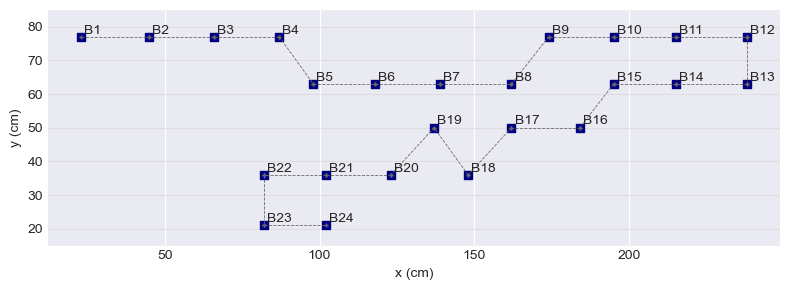

In [8]:
# Coordinates of the battery arrangment (center points).
x_coords = data['X/cm'].values
y_coords = data['Y/cm'].values

fig, ax = plt.subplots(figsize=(8,3))
ax.grid(which='major', axis='y', color='lightgrey', alpha=0.5)
ax.scatter(x_coords, y_coords, marker='s', s=40, c='navy')
for i in range(len(x_coords)-1):
    ax.plot([x_coords[i], x_coords[i+1]], [y_coords[i], y_coords[i+1]],
            ls='--', lw=0.6, marker='+', markersize=3, c='dimgrey')
eps = 1  # label offset (data coordinates)
for i, itext in enumerate(data['Battery'].values):
    ax.text(x_coords[i]+eps, y_coords[i]+eps, itext, fontsize=10, zorder=2)
ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
ax.set_ylim(15, 85)
fig.tight_layout()
plt.savefig('geometry.png', dpi=600)
plt.show()

In [9]:
# Battery centers (x,y) coordinates (meters).
coords = [(float(x)/100, float(y)/100) for x, y in zip(x_coords, y_coords)]
# Euclidean distances between battery center points.
d_mat = spatial.distance.cdist(coords, coords, metric='euclidean')
# Normalized battery connection resistances.
rij = data['Rij'].values / data['Rij'].values.sum()
# Connectivity graph.
r_mat = np.zeros(shape=(len(rij), len(rij)), dtype=float)
for i in range(len(rij)-1):
    for j in range(i+1, len(rij)):
        r_mat[i, j] = sum(rij[i:j])
        r_mat[j, i] = r_mat[i, j]
# Distance metric.
dm = r_mat + np.power(d_mat, 2)

#### Bayesian analysis

In [10]:
pct_error = 10.
n = len(data['Battery'].values)
noise = np.random.normal(loc=0, scale=pct_error/100, size=n)
data['deltaT'] = data['Ti(84)'] - data['Ti(0)'] + noise
delta_t = data['deltaT'].values
zi_data = data['Zi'].values
weights = (pct_error/100) * zi_data
index_values = data.index

In [11]:
c = {
    'id': data['Battery'].values
}
# Bayesian regression with Gaussian processes.
with pm.Model(coords=c) as mvt:
    # Data containers.
    x = pm.Data('x', delta_t)
    y = pm.Data('y', zi_data)
    idx = pm.Data('idx', index_values)
    # Covariance matrix.
    eta = pm.Exponential('eta', lam=2)
    rho = pm.Exponential('rho', lam=0.5)
    Kij = eta * np.exp(-rho * dm) + np.diag([0.01]*n)
    # Multivariate prior.
    gamma = pm.MvStudentT('gamma', nu=4, mu=np.zeros(n), cov=Kij, dims='id')
    # Additional priors.
    alpha = pm.Normal('alpha', mu=0, sigma=2)
    sigma = pm.HalfCauchy('sigma', beta=2)
    # Linear model.
    mu = alpha + x * gamma[idx]
    # Likelihood.
    obs = pm.StudentT('obs', nu=4, mu=mu, sigma=sigma,
                      observed=np.log(y), dims='id')
    # MCMC sampling.
    idata = pm.sample(draws=8000, tune=2000,
                      target_accept=0.99, max_treedepth=15,
                      idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, rho, gamma, alpha, sigma]


Output()

Sampling 4 chains for 2_000 tune and 8_000 draw iterations (8_000 + 32_000 draws total) took 722 seconds.


In [12]:
measurement_error = False
if measurement_error:
    # Bayesian regression with Gaussian processes
    # that incorporates measurement errors.
    with pm.Model(coords=c) as mvt:
        # Data containers.
        x = pm.Data('x', delta_t)
        y = pm.Data('y', zi_data)
        w = pm.Data('w', weights)
        idx = pm.Data('idx', index_values)
        # Covariance matrix.
        eta = pm.Exponential('eta', lam=2)
        rho = pm.Exponential('rho', lam=0.5)
        Kij = eta * np.exp(-rho * dm) + np.diag([0.01]*n)
        # Multivariate prior.
        gamma = pm.MvStudentT('gamma', nu=4, mu=np.zeros(n), cov=Kij, dims='id')
        # Additional priors.
        alpha = pm.Normal('alpha', mu=0, sigma=2)
        sigma = pm.HalfCauchy('sigma', beta=2)
        # Linear model.
        mu = alpha + x * gamma[idx]
        # Likelihood.
        est = pm.Normal('est', mu=mu, sigma=sigma)
        obs = pm.Normal('obs', mu=est, sigma=w, observed=np.log(y), dims='id')
        # MCMC sampling.
        idata = pm.sample(draws=6000, tune=2000,
                          target_accept=0.99, max_treedepth=15,
                          idata_kwargs={'log_likelihood': True})

In [13]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

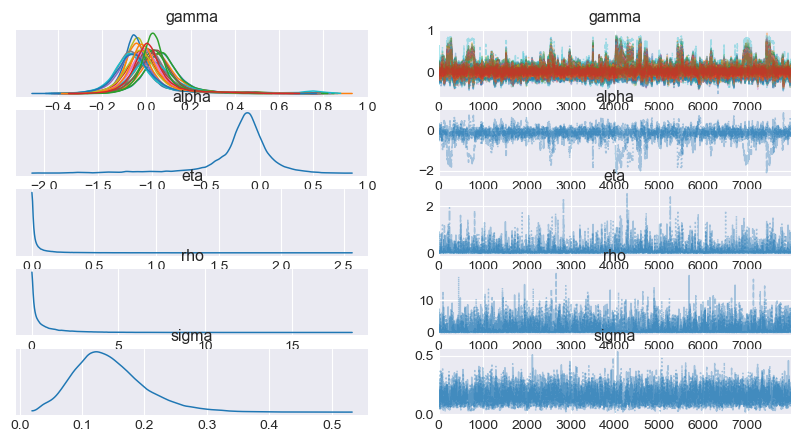

In [14]:
az.plot_trace(idata, figsize=(10, 5), combined=True);

In [15]:
print(az.summary(idata, kind='stats'))

             mean     sd  hdi_3%  hdi_97%
gamma[B1]   0.090  0.126  -0.144    0.327
gamma[B2]   0.075  0.132  -0.165    0.325
gamma[B3]   0.087  0.125  -0.142    0.326
gamma[B4]   0.037  0.116  -0.185    0.257
gamma[B5]   0.038  0.121  -0.185    0.272
gamma[B6]   0.031  0.119  -0.187    0.262
gamma[B7]   0.019  0.122  -0.213    0.250
gamma[B8]   0.038  0.121  -0.188    0.266
gamma[B9]  -0.023  0.087  -0.188    0.149
gamma[B10]  0.063  0.179  -0.232    0.348
gamma[B11] -0.034  0.084  -0.194    0.128
gamma[B12] -0.022  0.098  -0.212    0.166
gamma[B13]  0.052  0.118  -0.169    0.270
gamma[B14]  0.000  0.121  -0.226    0.231
gamma[B15] -0.030  0.118  -0.255    0.197
gamma[B16]  0.056  0.116  -0.175    0.267
gamma[B17]  0.012  0.117  -0.211    0.233
gamma[B18] -0.046  0.113  -0.260    0.175
gamma[B19] -0.006  0.118  -0.230    0.220
gamma[B20] -0.047  0.119  -0.270    0.183
gamma[B21] -0.036  0.122  -0.276    0.189
gamma[B22]  0.003  0.100  -0.186    0.197
gamma[B23]  0.043  0.083  -0.121  

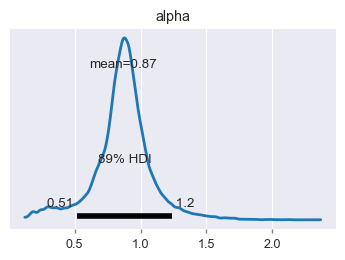

In [16]:
az.plot_posterior(idata, var_names=['alpha'], transform=np.exp,
                  hdi_prob=0.89, figsize=(4.2, 2.6), lw=2, textsize=9)
plt.show()

In [17]:
with mvt:
    # Posterior predictive samples for model checking.
    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [obs]


Output()

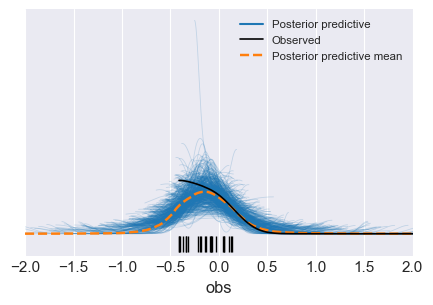

In [18]:
# Posterior predictive vs observed likelihood.
fig, ax = plt.subplots(figsize=(5, 3.2))
az.plot_ppc(idata, observed=True, observed_rug=True, 
            num_pp_samples=500, textsize=11, ax=ax)
ax.set_xlim(-2, 2)
plt.show()

In [19]:
eta = idata.posterior['eta'].mean(dim='chain').values
rho = idata.posterior['rho'].mean(dim='chain').values
Kij_post = eta.mean() * np.exp(-rho.mean() * dm) + np.diag([0.01]*n)
# Convert covariances to correlation matrix.
sigma_post = np.sqrt(np.diag(Kij_post))
sigma_post_inv = np.diag(sigma_post**-1)
Rho = sigma_post_inv @ Kij_post @ sigma_post_inv
Rho = pd.DataFrame(Rho, index=data['Battery'].values,
                   columns=data['Battery'].values)

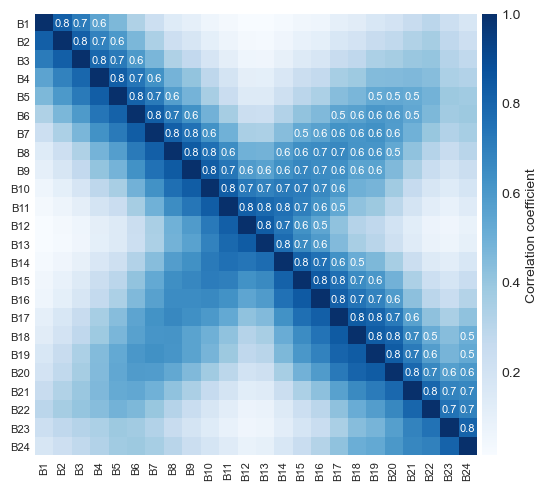

In [20]:
# Mean correlations.
fig, ax = plt.subplots(figsize=(6, 5))
ax.grid(False)
im = ax.imshow(Rho, cmap='Blues')
cb = plt.colorbar(im, ax=ax, pad=0.01, aspect=30)
cb.ax.set_ylabel('Correlation coefficient')
ax.set_xticks(range(n), data['Battery'].values, rotation=90, fontsize=8)
ax.set_yticks(range(n), data['Battery'].values, fontsize=8)
for i in range(n):
    for j in range(i+1, n):
        if Rho.values[i, j] > 0.5:
            text = ax.text(j, i, f'{Rho.values[i, j]:.1f}',
                           ha='center', va='center',
                           color='white', fontsize=8)
fig.tight_layout(pad=1.05)
plt.savefig('correlations.png', dpi=600)
plt.show()

In [21]:
alpha = idata.posterior['alpha'].mean(dim='chain')
gamma = idata.posterior['gamma'].mean(dim='chain')
# Retrodict impedances.
zi_retrodict = np.exp(alpha + delta_t * gamma[index_values])

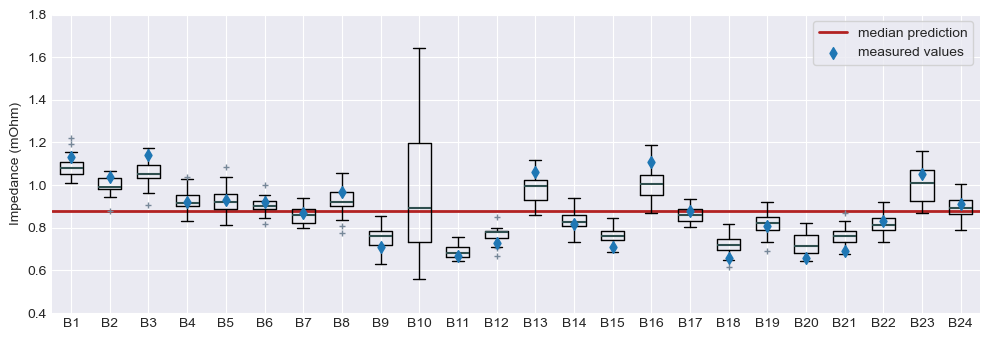

In [22]:
# Retrodictions.
labels = data['Battery'].values
zi_median = np.median(zi_retrodict, axis=0)
fig, ax = plt.subplots(figsize=(10, 3.5))
ax.axhline(np.median(zi_median), linestyle='-', linewidth=2, 
           color='firebrick', label='median prediction')
ax.boxplot(zi_retrodict, positions=range(len(labels)),
           widths=0.6, showmeans=False, showfliers=True,
           flierprops={'marker': '+', 'markersize': 5,
                       'markeredgecolor': 'lightslategrey'},
           medianprops={'color': 'darkslategrey', 'linewidth': 1.5})
ax.scatter(range(len(labels)), data['Zi'].values, marker='d',
           label='measured values', zorder=99)
ax.legend(loc='upper right', frameon=True, fancybox=True, framealpha=0.8)
ax.set_xticklabels(labels)
ax.set_ylabel('Impedance (mOhm)')
ax.set_ylim(0.4, 1.8)
fig.tight_layout()
plt.savefig('retrodictions.png', dpi=600)
plt.show()

#### Predictions on the test measurements (second cycle)

In [15]:
# Test set (second measurement).
test = dataset[discharges[1]].copy()

In [24]:
test['delta_t'] = test['Ti(84)'] - test['Ti(0)'] + noise
dt_test = test['delta_t'].values
y_test = test['Zi'].values
w_test = (pct_error/100) * y_test

In [25]:
with mvt:
    pm.set_data({'x': dt_test})
    pm.set_data({'y': y_test})
    y_predict = pm.sample_posterior_predictive(idata, predictions=True)

Sampling: [obs]


Output()

In [26]:
# Predicted Zi values from the test set.
zi_predict = np.exp(y_predict.predictions['obs'].median(dim='chain').values)
# Median predicted impedance value.
y_pred = np.exp(y_predict.predictions['obs'].median(dim=['chain', 'draw']).values)

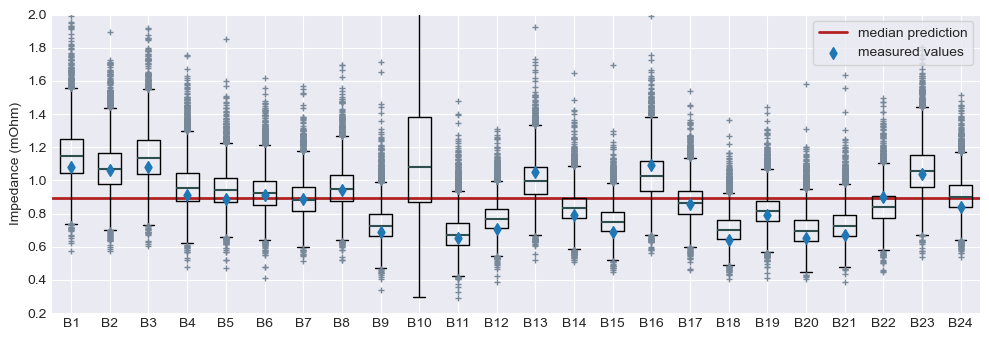

In [27]:
# Predictions.
fig, ax = plt.subplots(figsize=(10, 3.5))
ax.axhline(np.median(y_pred), linestyle='-', linewidth=2, 
           color='firebrick', label='median prediction')
ax.boxplot(zi_predict, positions=range(len(labels)),
           widths=0.6, showmeans=False, showfliers=True,
           flierprops={'marker': '+', 'markersize': 4,
                       'markeredgecolor': 'lightslategrey'},
           medianprops={'color': 'darkslategrey', 'linewidth': 1.5})
ax.scatter(range(len(labels)), y_test, marker='d',
           label='measured values', zorder=99)
ax.legend(loc='upper right', frameon=True, fancybox=True, framealpha=0.8)
ax.set_xticklabels(labels)
ax.set_ylabel('Impedance (mOhm)')
ax.set_ylim(0.2, 2)
fig.tight_layout()
plt.savefig('predictions.png', dpi=600)
plt.show()

In [28]:
# RMSE and MAPE errors.
rmse = root_mean_squared_error(y_test, y_pred)
print(f'RMSE: {rmse:.2f} (mOhm)')
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE: {mape*100:.2f} %')

RMSE: 3.14 (mOhm)
MAPE: 8.38 %


#### Battery discharge curves Q(V)

In [ ]:
qdata = dataset[discharges[1]].copy()
qdata.drop(index=9, inplace=True)  # B10
qdata.reset_index(drop=True, inplace=True)

In [ ]:
capacity = pd.read_excel(file_name, sheet_name='Kapacitet')
capacity.dropna(axis='columns', inplace=True)  # remove empty columns

In [31]:
c_bat = capacity.iloc[2, 2:].values  # 05-12-25

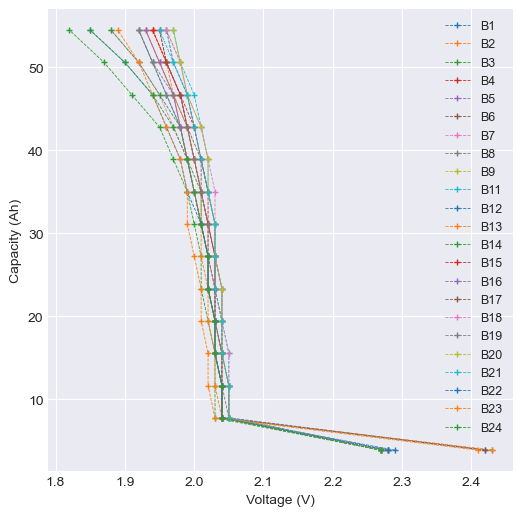

In [32]:
stride = 5
fig, ax = plt.subplots(figsize=(6, 6))
for i in qdata.index:
    bat = qdata['Battery'].iloc[i]
    ax.plot(qdata.iloc[i, stride:stride+len(c_bat)].values, c_bat,
            ls='--', lw=0.6, marker='+', ms=4, label=f'{bat}')
ax.legend(fontsize=9)
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Capacity (Ah)')
plt.show()

In [33]:
THR = 10.  # threshold
ib = np.argwhere(c_bat < THR)[-1]
dqdv = np.empty(len(qdata.index))
for i in qdata.index:
    vb = qdata.iloc[i, stride:stride+len(c_bat)]
    dqdv[i] = abs(c_bat[-1] - c_bat[ib]) / abs(vb[ib] - vb[-1])
qdata['dqdv'] = dqdv

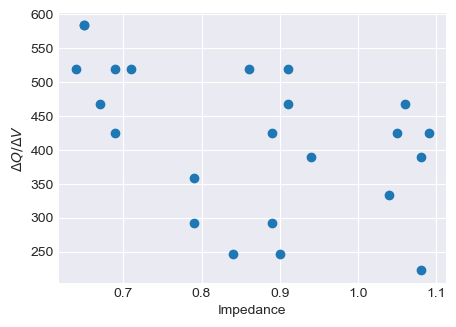

In [34]:
fig, ax = plt.subplots(figsize=(5, 3.5))
ax.scatter(qdata['Zi'].values, qdata['dqdv'].values)
ax.set_xlabel('Impedance')
ax.set_ylabel(r'$\Delta Q / \Delta V$')
plt.show()

In [35]:
# Standardize.
scale = StandardScaler()
dqdv = scale.fit_transform(dqdv.reshape(-1, 1)).flatten()

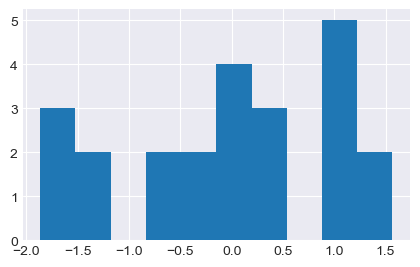

In [36]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.hist(dqdv)
plt.show()